# パイプラインによるワークフローの効率化

In [0]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [0]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [0]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.20, random_state=1)

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 連結する処理としてスケーリング、主成分分析、ロジスティック回帰を指定
pipe_lr = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


# k分割交差検証を使ったモデルの性能の評価

In [0]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# 分割元データ、分割数、乱数生成器んも状態を指定し、
# 層化k分割交差検証イテレータを表す StratifiedKFold クラスのインスタンス化
kfold = StratifiedKFold(n_splits=10, 
                        random_state=1)

scores = []
# イテレータのインデックスと要素をループ処理
#   データをモデルに適合
#   テストデータの正解率を算出
#   リストに正解率を追加
#   分割の番号、0以上の要素数、正解率を出力
for k, (train, test) in enumerate(kfold.split(X_train, y_train)): # X_train は別に np.zeros で埋めても良い（形は必要）
  pipe_lr.fit(X_train[train], y_train[train])
  score = pipe_lr.score(X_train[test], y_train[test])
  scores.append(score)
  print('Fold: %s, Class dist.: %s, Acc: %.3f' %
        (k+1, np.bincount(y_train[train]), score))

# 正解率の平均と標準偏差を出力
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.913
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956
CV accuracy: 0.952 +/- 0.025


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [0]:
from sklearn.model_selection import cross_val_score

# 交差検証の cross_val_score 関数でモデルの正解率を算出
# 推定器 estimator, トレーニングデータ X, 予測値 y, 分割数 cv, CPU数 n_jobs を指定
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.91304348 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]
CV accuracy: 0.952 +/- 0.025


# 学習曲線と検証曲線によるアルゴリズムの診断

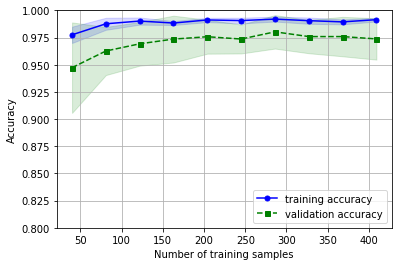

In [0]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])
# learning_curve 関数で交差検証による正解率を算出
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5,
         label='training accuracy')

# fill_between 関数で平均 ± 標準偏差の項を塗りつぶす
# トレーニングデータのサイズ train_sizes, 透明度 alpha, カラー 'blue' を引数に設定
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


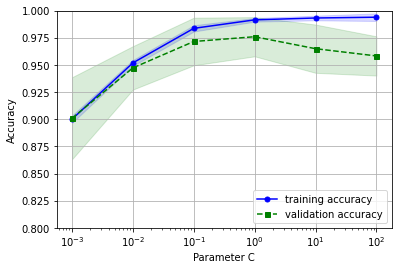

In [0]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
# validation_curve 関数によりモデルのパラメータを変化させ、
# 交差検証による正解率を算出
# clf_C は LogisticRegression オブジェクトのパラメータ
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name='clf__C',
                                             param_range=param_range,
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5,
         label='training accuracy')
plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

# グリッドサーチによる機械学習モデルのトレーニング

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']},
               {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}]
# ハイパーパラメータ値のリスト param_grid を指定し、
# グリッドサーチを行う GridSearchCV クラスのインスタンス化
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
# モデルの最良スコアを出力
print(gs.best_score_)

0.9781159420289856


In [0]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


In [0]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [0]:
from sklearn.tree import DecisionTreeClassifier

# ハイパーパラメータ値として決定木の深さパラメータを指定し、
# グリッドサーチを行う GridSearchCV クラスをインスタンス化
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs,
                         X_train,
                         y_train,
                         scoring='accuracy',
                         cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.029


# 様々な性能評価指標

In [0]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


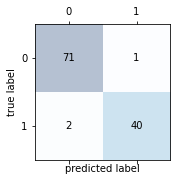

In [0]:
# 図のサイズを指定
fig, ax = plt.subplots(figsize=(2.5, 2.5))
# matshow 関数で行列からヒートマップを描画
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [0]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


TypeError: ignored

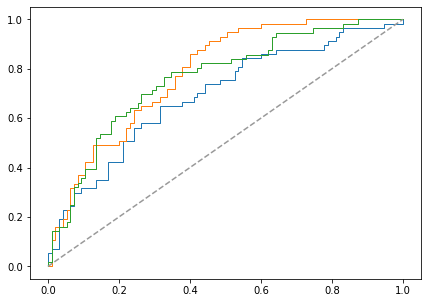

In [0]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                     ('clf', LogisticRegression(penalty='l2',
                                                random_state=0,
                                                C=100.00))])
X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(n_splits=3, random_state=1).split(X_train2, y_train)
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
  probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
  fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
  mean_tpr += interp(mean_fpr, fpr, tpr)
  mean_tpr[0] = 0.0
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr,
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Opeartor Characteristic')
plt.legend(loc='lower right')
plt.show() 